# Discriminant Analysis of Principal Components
## Temporal Structure of Blackfin tuna

In [36]:
library(adegenet) 
library(dplyr)
library(tidyr)
library(magrittr)
library(ggpubr)
set.seed(6969)
my_pal <- c("#f1c232", "#d08120", "#54438a", "#655595", "#2a2145","#66b2b2", "#008080", "#006666", "#ff8181")
pal4 <- my_pal[c(1,4,6,9)]

Load in the file(s)

In [2]:
infile <- "../inputfiles/bft.kinless.gen"
bft <- read.genepop(infile, ncode = 3L, quiet = T)
metadata <- read.csv("../inputfiles/bft.strata", sep = ",", header = T)

Adding Population-Year as the `pop` information

In [3]:
metadata$locyear <- paste(metadata$pop4, metadata$year, sep = "-")

pop(bft) <- metadata$locyear
yearID <- metadata$year
localID <- metadata$pop4
regionID <- metadata$pop3

### Final Optimal number of Principal Components
Use cross validation to determine optimal number of PCs to keep. The first cross-validation is performed between 1 and 300 in increments of 10. This can be considered a "coarse" search.

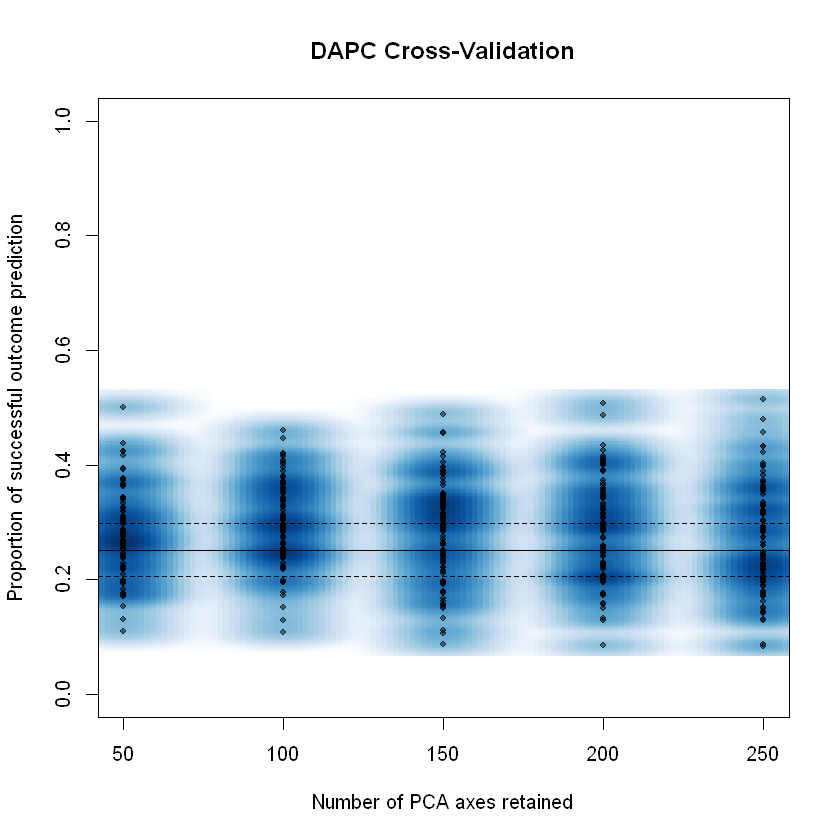

In [4]:
crossval <- xvalDapc(tab(bft, NA.method="mean"), regionID, n.pca.max=300, n.rep=100,  parallel = "multicore", ncpus = 4)
cv.pc <- crossval$`Number of PCs Achieving Highest Mean Success`

In [5]:
cv.pc <- as.numeric(cv.pc)
cv.range <- (cv.pc - 10):(cv.pc + 10)
cv.range

[1]  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
[20] 109 110

It suggests around 100 PCs, so now perform a "fine" search of 100 +- 10 in increments of 1

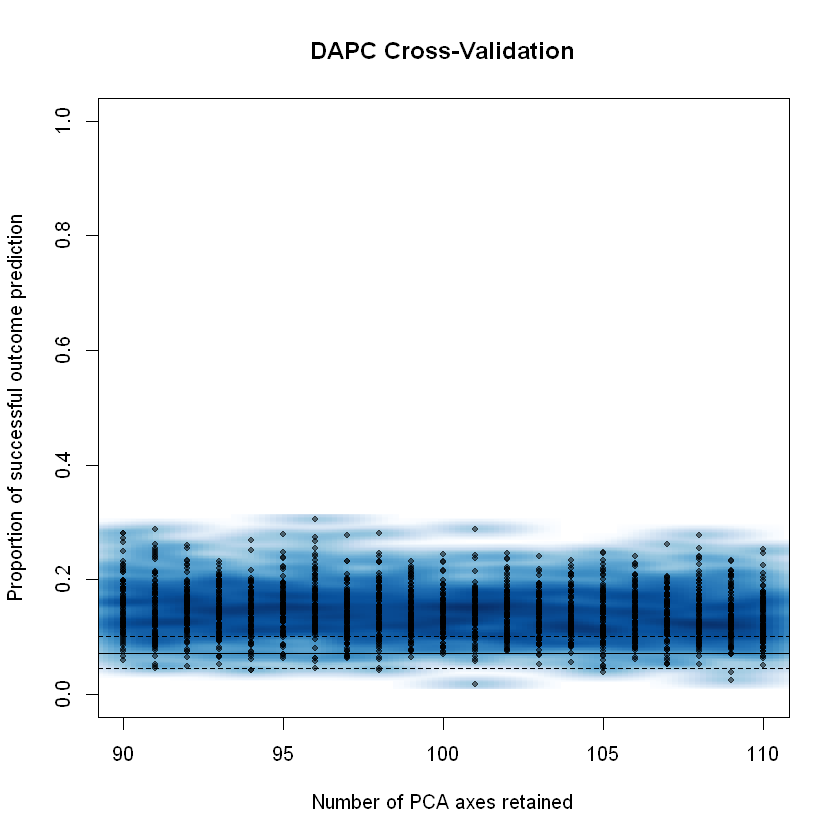

In [6]:
dapc <- xvalDapc(tab(bft, NA.method="mean"), pop(bft), n.pca=cv.range, n.rep=100,  parallel = "multicore", ncpus = 4)

Save the optimal PC number

In [7]:
pcval <- 90
print(paste("Optimal PC:", pcval))

[1] "Optimal PC: 90"


### K-means clustering
Iteratively perform K-means clustering from K-values 1 to 9, each value of K performed 50 times.

In [8]:
maxK <- 9
myMat <- matrix(nrow=50, ncol=maxK)
colnames(myMat) <- 1:maxK
for(i in 1:nrow(myMat)){
  grp <- find.clusters(bft, n.pca = pcval, choose.n.clust = FALSE,  max.n.clust = maxK)
  myMat[i,] <- grp$Kstat
}

Format the matrix for plotting

In [9]:
k_df <- reshape2::melt(myMat)
colnames(k_df)[1:3] <- c("Group", "K", "BIC")
k_df$K <- as.factor(k_df$K)

Plot the results

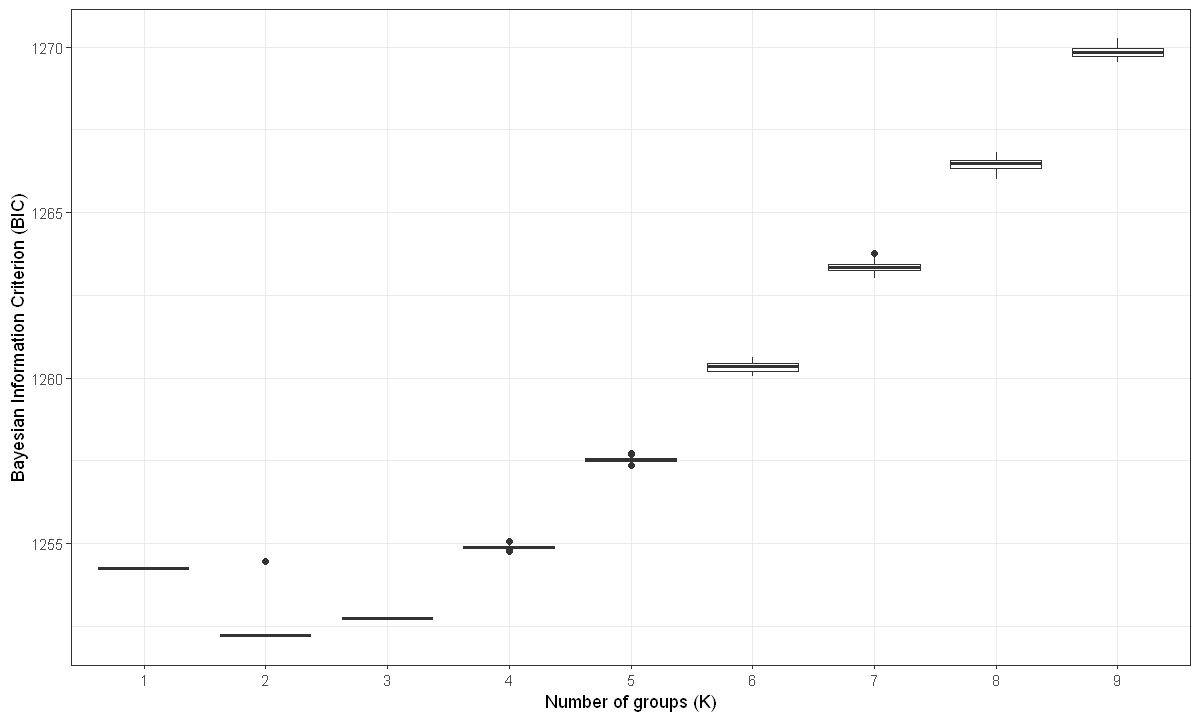

In [10]:
options(repr.plot.width=10, repr.plot.height=6)
k.plot <- k_df %>% 
  ggplot(aes(x = K, y = BIC)) +
  geom_boxplot() +
  theme_bw() +
  ylab("Bayesian Information Criterion (BIC)") +
  xlab("Number of groups (K)")

k.plot

### DAPC
Perform DAPC again, this time using the optimal PC and the K-means assignments

In [11]:
dapc.res <- dapc(bft, pop = regionID, n.pca = pcval, n.da = 5)

## Plot by Locality

In [24]:
dapc.df <- as.data.frame(dapc.res$ind.coord, col.names = colnames(dapc.res$ind.coord))
dapc.df <- cbind(rownames(dapc.res$ind.coord), dapc.res$grp, localID, dapc.df)
names(dapc.df) <- c("name", "year", "locality", "LD1", "LD2", "LD3")
dapc.df %<>% mutate(year = factor(yearID, levels = c(2015, 2016, 2017, 2018), ordered = TRUE))
dapc.df$locality <- factor(localID, levels = c("BRZ", "BRZSP", "MRT", "VZ", "PR", "TX", "PNS", "KEY", "SCA"), ordered = TRUE)
dapc.df$region <- factor(regionID, levels = c("ATL","GULF","CRB", "BRZ"))
dapc.df %<>% group_by(year) %>% 
  mutate(centroid1.yr = mean(LD1), centroid2.yr = mean(LD2)) %>%
  group_by(locality) %>%
  mutate(centroid1.loc = mean(LD1), centroid2.loc = mean(LD2)) %>%
  group_by(region) %>%
  mutate(centroid1.reg = mean(LD1), centroid2.reg = mean(LD2), centroid3.reg = mean(LD3))

head(dapc.df)

name,year,locality,LD1,LD2,LD3,region,centroid1.yr,centroid2.yr,centroid1.loc,centroid2.loc,centroid1.reg,centroid2.reg,centroid3.reg
<chr>,<ord>,<ord>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BRZ_1261,2016,BRZ,-0.5650872,0.87505864,-0.2410065,BRZ,0.3186283,0.02734102,-1.575928,-0.3220199,-1.749039,-0.2620657,-1.036215
BRZ_1269,2016,BRZ,-1.8858011,-0.05055265,-0.6019511,BRZ,0.3186283,0.02734102,-1.575928,-0.3220199,-1.749039,-0.2620657,-1.036215
BRZ_1270,2016,BRZ,-0.1338599,1.19815726,0.2669529,BRZ,0.3186283,0.02734102,-1.575928,-0.3220199,-1.749039,-0.2620657,-1.036215
BRZ_1271,2016,BRZ,-2.4537443,-0.78889716,-1.8751400,BRZ,0.3186283,0.02734102,-1.575928,-0.3220199,-1.749039,-0.2620657,-1.036215
BRZ_1275,2016,BRZ,-0.3607020,-0.25993433,-2.1009310,BRZ,0.3186283,0.02734102,-1.575928,-0.3220199,-1.749039,-0.2620657,-1.036215
BRZ_1276,2016,BRZ,-1.5188430,0.25660171,-1.4690530,BRZ,0.3186283,0.02734102,-1.575928,-0.3220199,-1.749039,-0.2620657,-1.036215


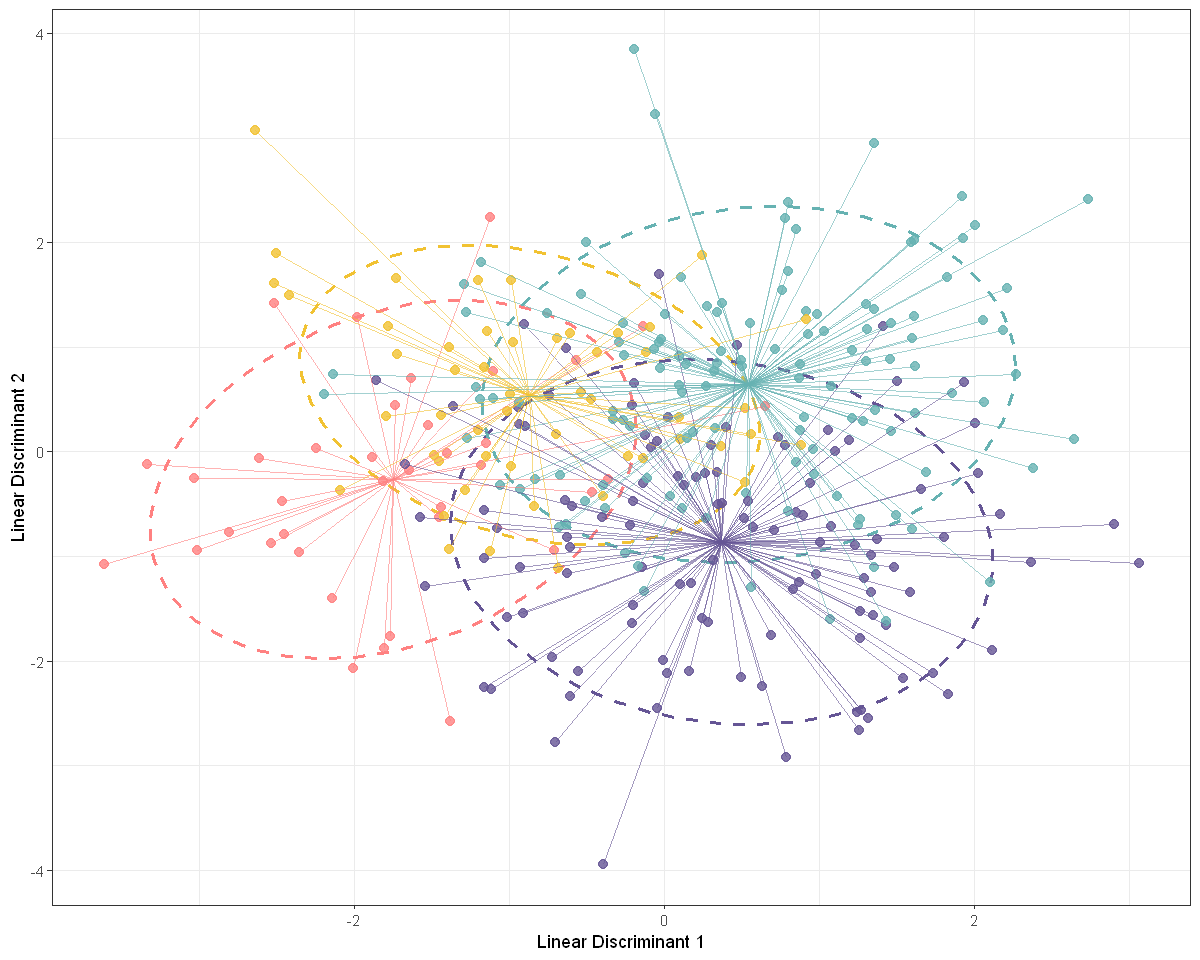

In [30]:
options(repr.plot.width=10, repr.plot.height=8)
dapc.plt.reg <- dapc.df %>% 
  ggplot(aes(x = LD1, y = LD2)) +
  stat_ellipse(linetype = 2, linewidth = 1, show.legend = FALSE, type = "norm", level = 0.75, segments = 100, aes(color = region)) +
  geom_point(size = 2.4, alpha = 0.8, aes(color = region, fill = region)) +
  geom_segment(data = dapc.df, alpha = 0.6, aes(x = centroid1.reg, y = centroid2.reg, xend = LD1, yend = LD2, color = region)) +
  xlab("Linear Discriminant 1") +
  ylab("Linear Discriminant 2") +
  scale_color_manual(values=pal4, name = "Region") +
  scale_fill_manual(values=c(paste(pal4, "96", sep = "")), name = "Region") +
  theme_bw() +
  theme(legend.position = "none")
dapc.plt.reg

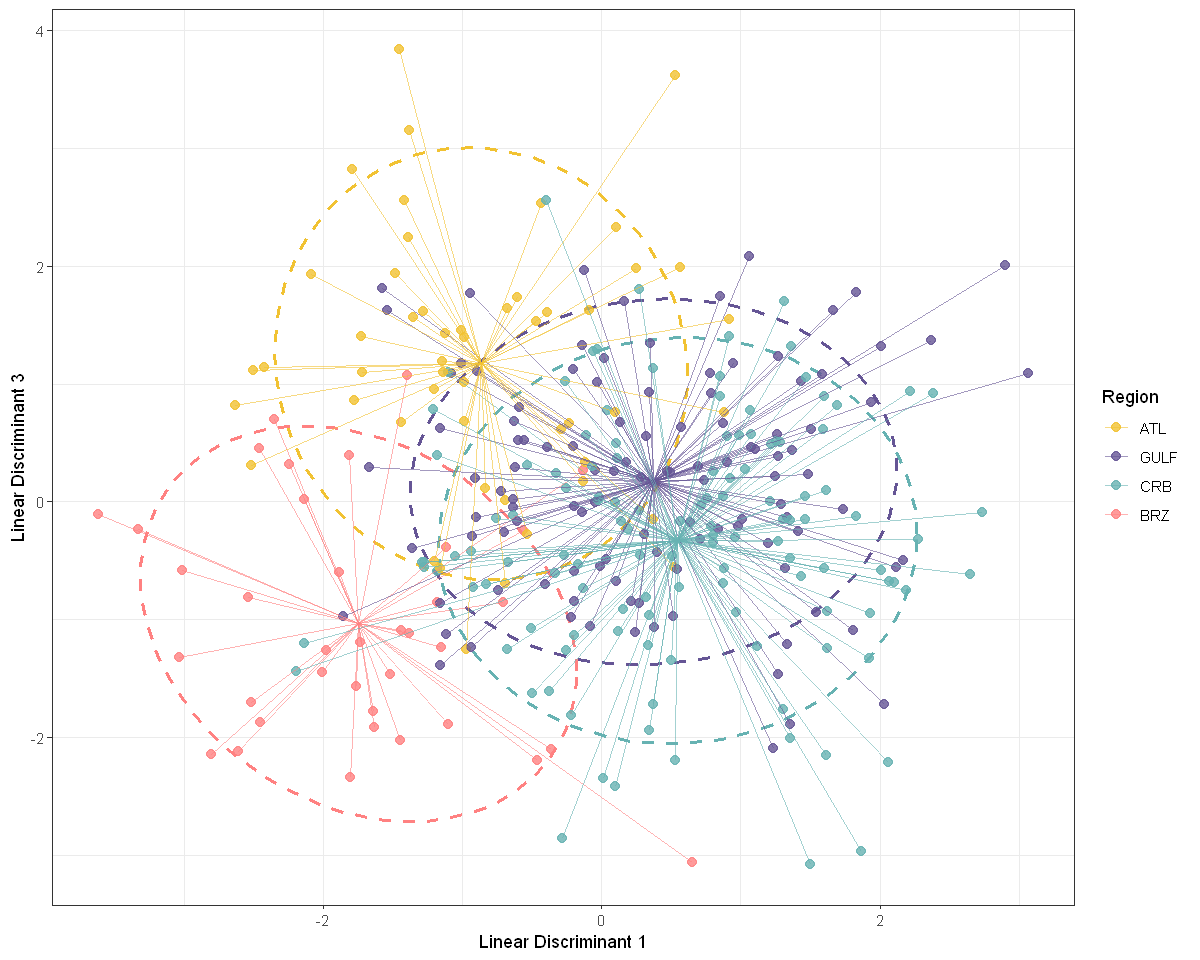

In [28]:
options(repr.plot.width=10, repr.plot.height=8)
dapc.plt.reg23 <- dapc.df %>% 
  ggplot(aes(x = LD1, y = LD3)) +
  stat_ellipse(linetype = 2, linewidth = 1, show.legend = FALSE, type = "norm", level = 0.75, segments = 100, aes(color = region)) +
  geom_point(size = 2.4, alpha = 0.8, aes(color = region, fill = region)) +
  geom_segment(data = dapc.df, alpha = 0.6, aes(x = centroid1.reg, y = centroid3.reg, xend = LD1, yend = LD3, color = region)) +
  xlab("Linear Discriminant 1") +
  ylab("Linear Discriminant 3") +
  scale_color_manual(values=pal4, name = "Region") +
  scale_fill_manual(values=c(paste(pal4, "96", sep = "")), name = "Region") +
  theme_bw() +
  theme(legend.position = "right")
dapc.plt.reg23

### Posterior Membership Plot
Making the stacked barplot, similar to how STRUCTURE results are presented

In [31]:
tmp <- as.data.frame(dapc.res$posterior)
tmp <- cbind(indNames(bft), bft$pop, tmp)
names(tmp) <- c("name", "origin", "1", "2", "3", "4")
tmp$origin <- metadata$pop4
tmp$origin <- paste(metadata$pop4, metadata$year, sep = "\n")
assignments <- pivot_longer(tmp, c(-name, -origin), names_to = "assignment", values_to = "posterior")
head(assignments)

name,origin,assignment,posterior
<chr>,<chr>,<chr>,<dbl>
BRZ_1261,BRZ 2016,1,0.16419251
BRZ_1261,BRZ 2016,2,0.06793298
BRZ_1261,BRZ 2016,3,0.62423102
BRZ_1261,BRZ 2016,4,0.14364348
BRZ_1269,BRZ 2016,1,0.11081454
BRZ_1269,BRZ 2016,2,0.68736361


Plot the data

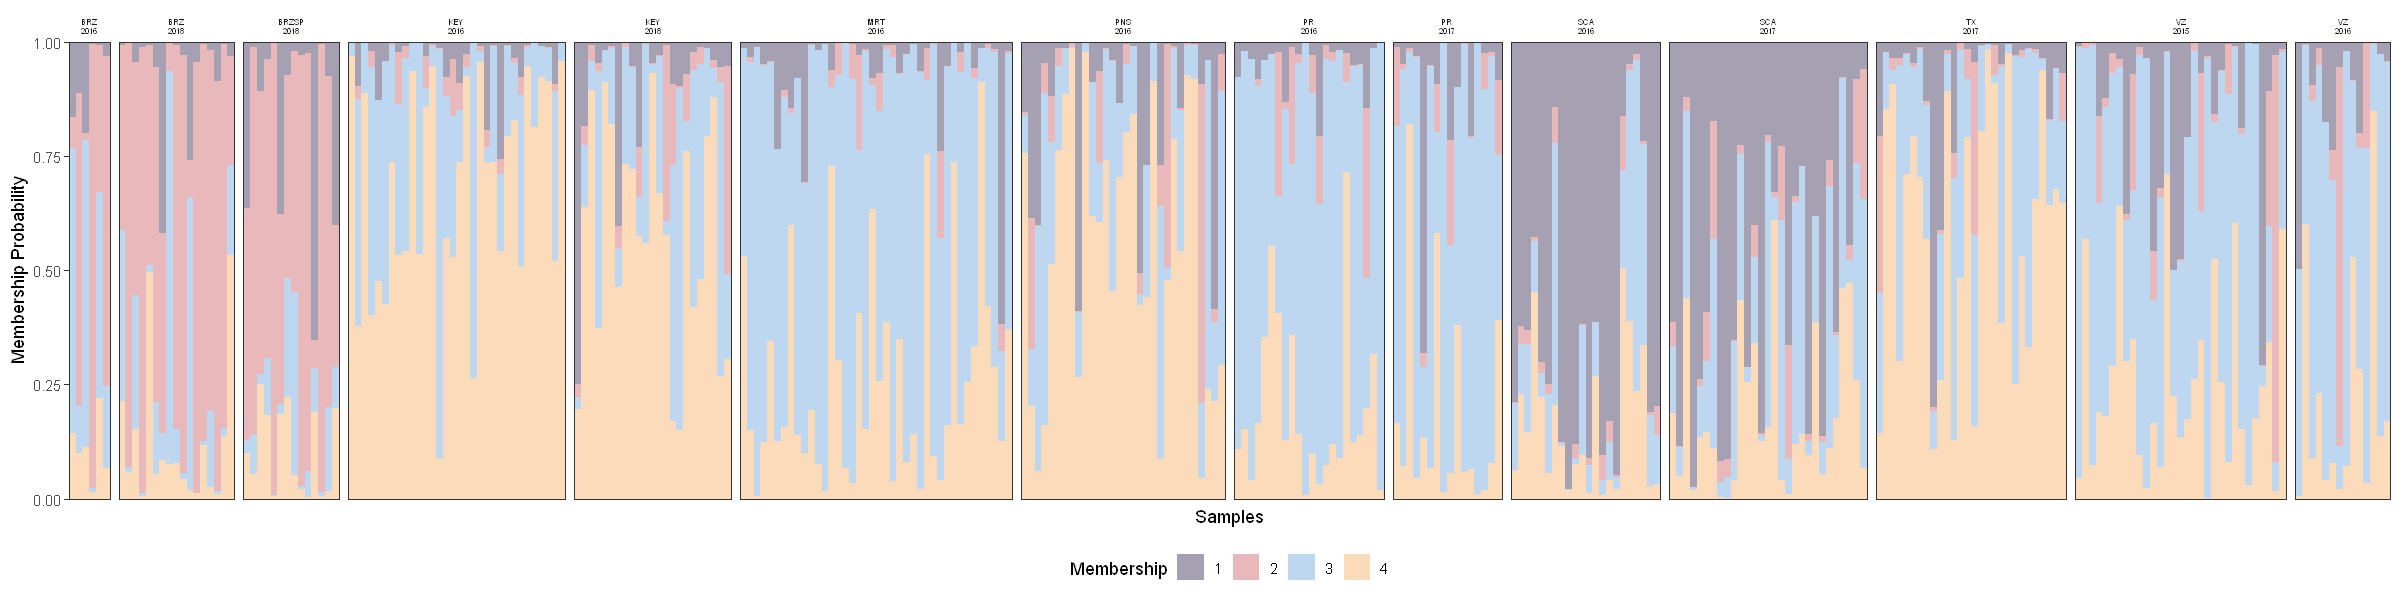

In [32]:
options(repr.plot.width=20, repr.plot.height=5)
posterior_plot <- assignments %>% 
  ggplot(aes(x = name, y = posterior, fill = assignment)) +
  geom_bar(stat = "identity", width = 1.0, alpha = 0.7) +
  scale_fill_manual(values = c("#7e7892", "#de999e", "#9fc5e8", "#f9cb9c")) +
  ylab( "Membership Probability") +
  xlab("Samples") +
  facet_grid(~origin, scales = "free_x", space = "free" ) + 
  theme_bw() +
  guides(fill=guide_legend(title="Membership")) +
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        strip.background = element_blank(),
        strip.text.x = element_text(size = 5),
        legend.position = "bottom") +
  coord_cartesian(ylim = c(0, 1), expand = FALSE, clip = "off")

posterior_plot

Combine all three as a single plot

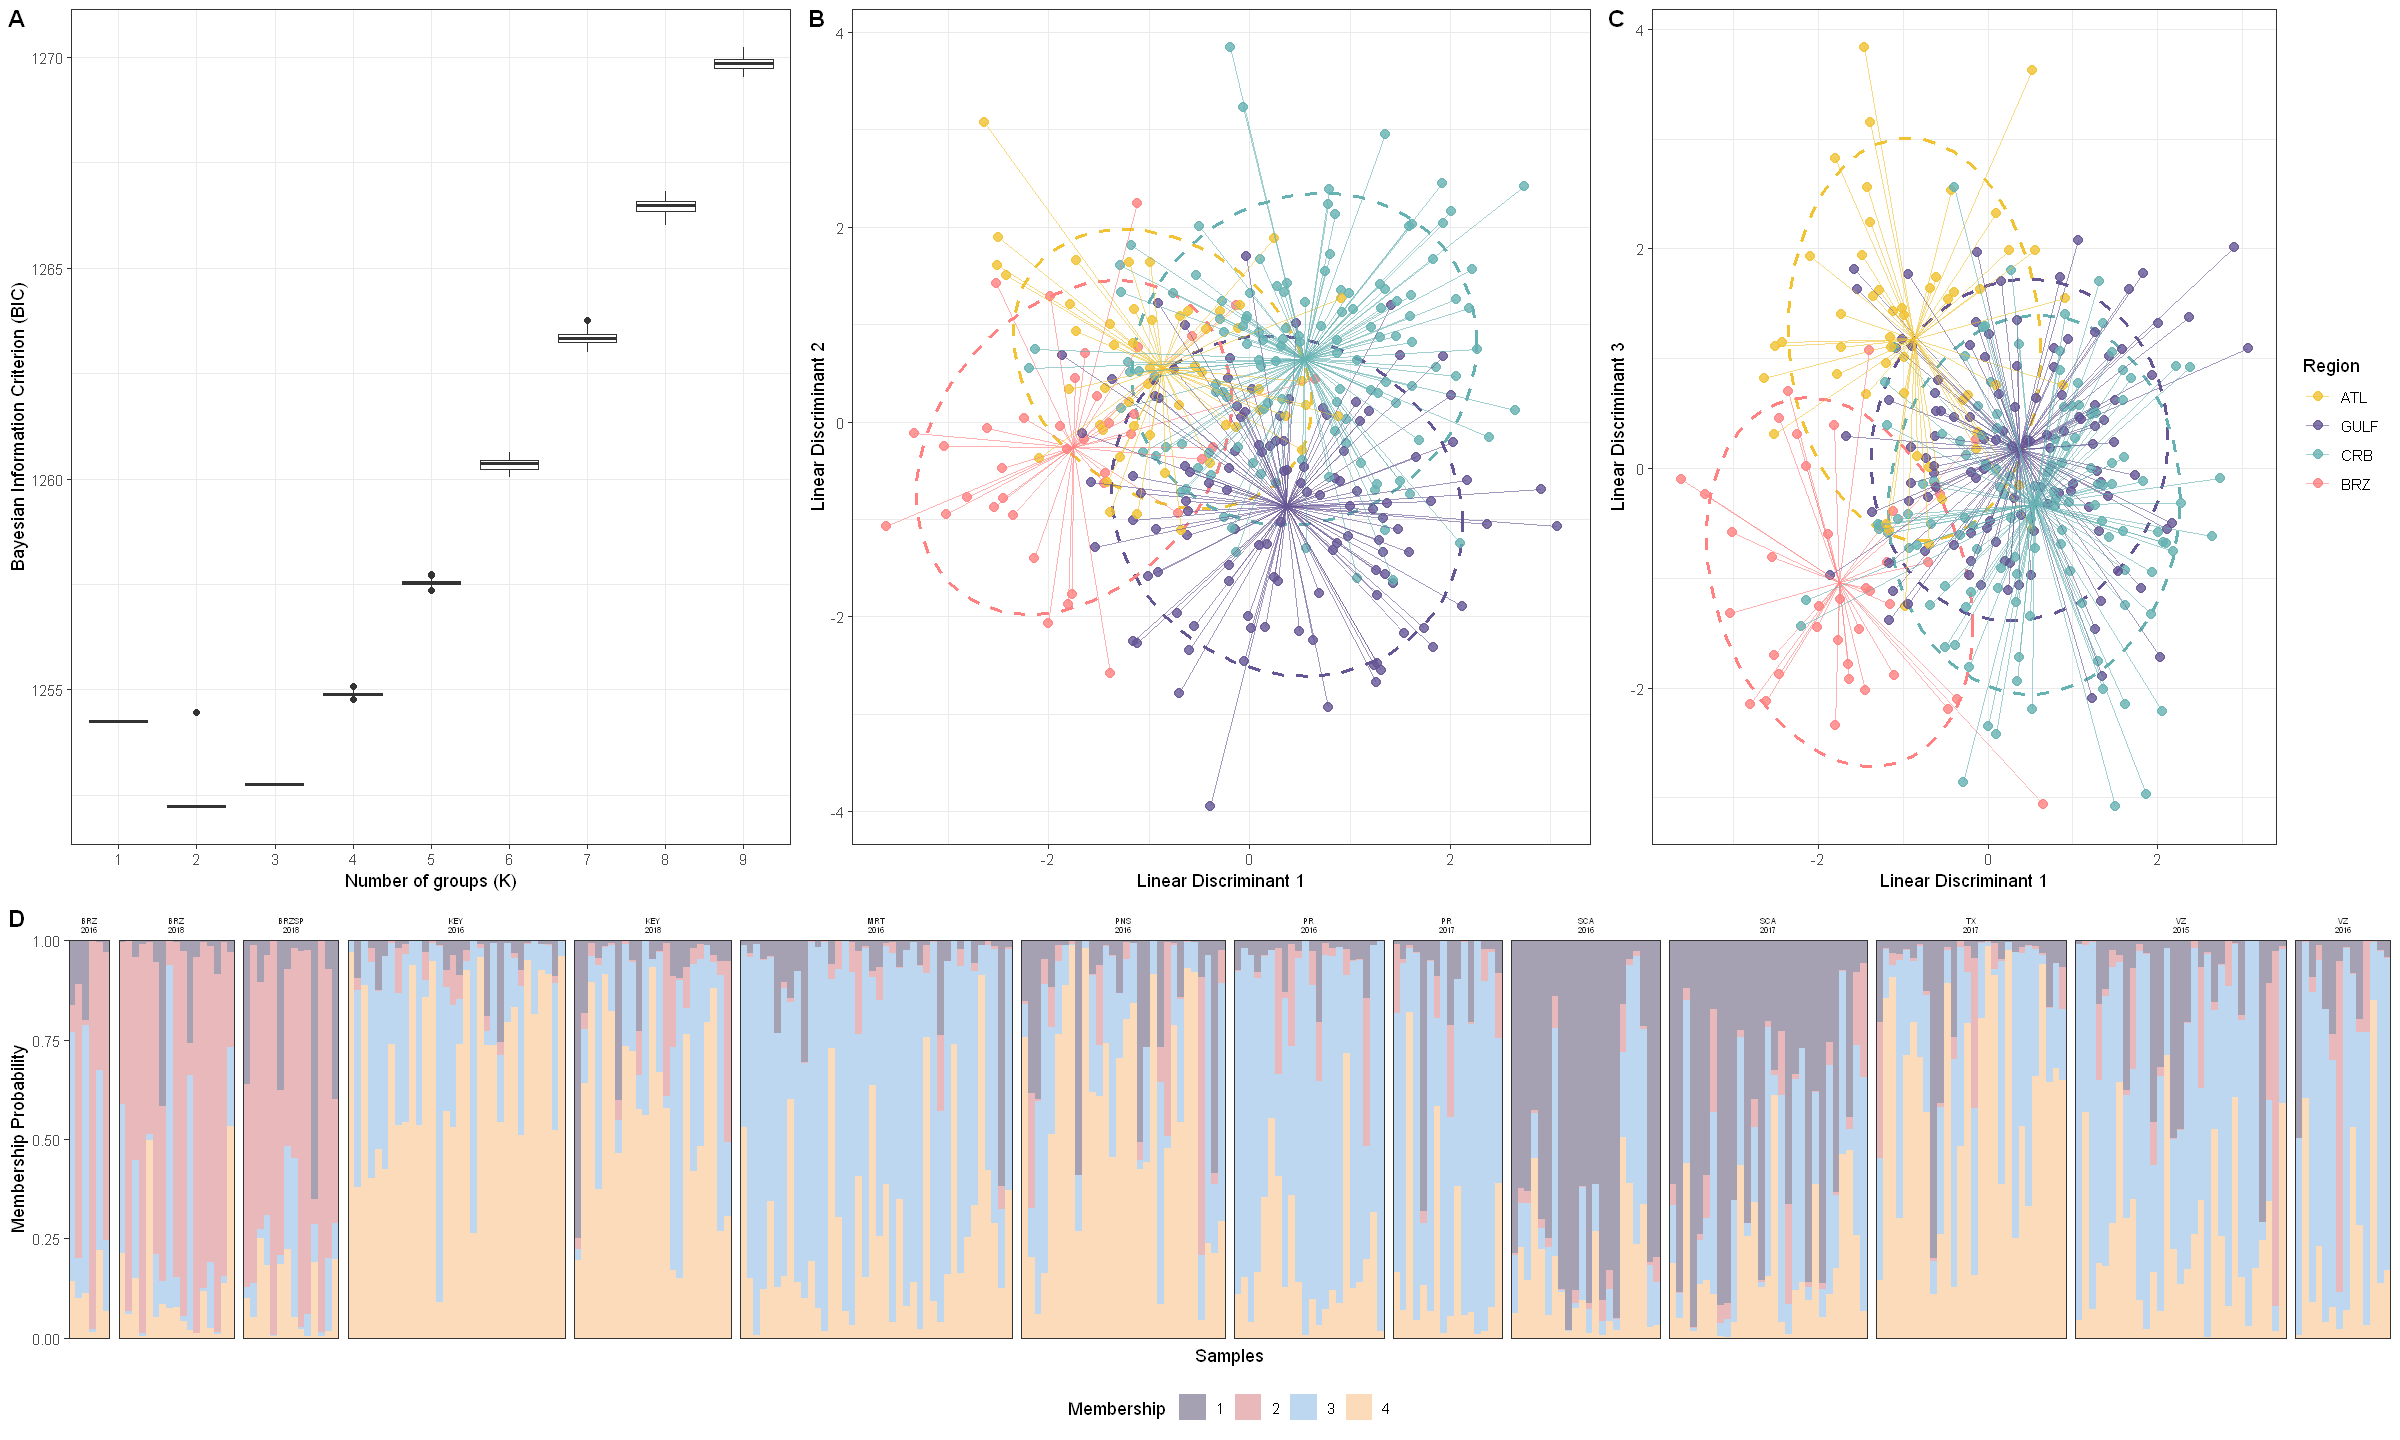

In [34]:
options(repr.plot.width=20, repr.plot.height=12)
ggarrange(
  ggarrange(
    k.plot,
    dapc.plt.reg,
    dapc.plt.reg23,
    ncol = 3, 
    labels = c("A", "B", "C")
  ),
  posterior_plot,
  nrow = 2,
  labels = c("", "D"),
  heights = c(2, 1.2)
)

Save it

In [35]:
ggsave("dapc_4prior.jpg", height = 8, width = 14, units = "in", dpi = 450)